In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Funtion to get the tf_idf scores for a list of strings representing a title
# takes a list of strings as parameters
def pre_tfidf2(data):
    nr_pattern = re.compile(r'\b[+-]?\d*[.,]?\d+([eE][+-]?\d+)?\b')
    non_alphanum = re.compile(r'[^\w\d\-\+]')
    for i in range(len(data)):
        title = non_alphanum.sub(' ', data[i])
        data[i] = nr_pattern.sub('NUMBER_SPECIAL_TOKEN', title)
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=500)
    X = vectorizer.fit_transform(data)
    return X.toarray()

# reading the data
dt_true = pd.read_csv('clickbait_data.txt', sep='\n', names=['Title'])
dt_false = pd.read_csv('non_clickbait_data.txt', sep='\n', names=['Title'])
dt_true = dt_true.assign(Label = lambda x: True)
dt_false = dt_false.assign(Label = lambda x: False)

# merging the data
dt = pd.concat([dt_true, dt_false], ignore_index=True)

# shulffing data
dt = shuffle(dt).reset_index(drop=True)

# computing tf-idf
X = pre_tfidf2(dt['Title'].to_list()) # tf_idf scores
y = dt['Label'] # labels

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Separation into data and label
print(X.shape)
print(y.shape)

(32000, 500)
(32000,)


In [3]:
# Train on data. No parameters to adjust

from sklearn.naive_bayes import GaussianNB       ### Because continuous data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.neighbors as nb

cv = StratifiedKFold(n_splits=10) 

gnb = GaussianNB()
cv_scores = cross_val_score(gnb,X=X,y=y,cv=cv)
np.mean(cv_scores)


0.88653125

In [4]:
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

predicted = cross_val_predict(GaussianNB(), X=X, y=y,  cv=cv)  

print(confusion_matrix(y, predicted))
print(accuracy_score(y, predicted))

[[14700  1301]
 [ 2330 13669]]
0.88653125


In [5]:
from sklearn.metrics import classification_report

print(classification_report(y, predicted))

              precision    recall  f1-score   support

       False       0.86      0.92      0.89     16001
        True       0.91      0.85      0.88     15999

    accuracy                           0.89     32000
   macro avg       0.89      0.89      0.89     32000
weighted avg       0.89      0.89      0.89     32000



## Adjusting probability threshold

In [6]:
# Focus on predict class 1

y2 = np.zeros((y.shape))
y2[y==0]=1
y2[y==1]=0

(X_train, X_test,  y_train, y_test) = train_test_split(X, y2, test_size=.3, random_state=1)



In [7]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def filterp(th,ProbClass1):
    """ Given a treshold "th" and a set of probabilies of belonging to class 1 "ProbClass1", return predictions """ 
    y=np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf = GaussianNB()
lth=[]

# We do a 10 fold crossvalidation with 10 iterations
kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_train, y_train):
    X_train2, X_test2 = X[train_index], X[test_index]
    y_train2, y_test2 = y2[train_index], y2[test_index]

    # Train with the training data of the iteration 
    clf.fit(X_train2, y_train2)
    # Obtaining probablity predictions for test data of the iterarion
    probs = clf.predict_proba(X_test2)
    # Collect probabilities of belonging to class 1
    ProbClass1 = probs[:,1]
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold) 
    res = np.array([[th,f1_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])

    # Uncomment the following lines if you want to plot at each iteration how f1-score evolves increasing the threshold 
    #plt.plot(res[:,0],res[:,1])
    #plt.show()

    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 10 iterations    
thdef = np.mean(lth)
print("Selected threshold in 10-fold cross validation:", thdef)
print()

Selected threshold in 10-fold cross validation: 0.3980735275926413



In [8]:
# Train a classifier with the whole training data 
clf = GaussianNB()
clf.fit(X_train, y_train)
# Obtain probabilities for data on test set
probs = clf.predict_proba(X_test)
# Generate predictions using probabilities and threshold found on 10 folds cross-validation


In [9]:
pred = filterp(thdef,probs[:,1])
# Print results with this prediction vector
print(classification_report(y_test, pred))

# Ignore warnings explaining that in some iterations f1 score is 0

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      4892
         1.0       0.87      0.90      0.89      4708

    accuracy                           0.89      9600
   macro avg       0.89      0.89      0.89      9600
weighted avg       0.89      0.89      0.89      9600



In [10]:
clf = GaussianNB()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      4892
         1.0       0.87      0.90      0.89      4708

    accuracy                           0.89      9600
   macro avg       0.89      0.89      0.89      9600
weighted avg       0.89      0.89      0.89      9600



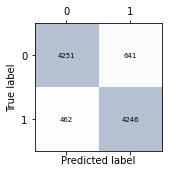

In [11]:
confmat = sklearn.metrics.confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix.png', dpi=600)
plt.show()